![](./img/DCGAN%20model%20from%20text%20to%20image.png)

# 1. Dataset

In [1]:
# Download dataset
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU


Downloading...
From (original): https://drive.google.com/uc?id=1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
From (redirected): https://drive.google.com/uc?id=1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU&confirm=t&uuid=773199c2-8c8c-491f-95bc-ad19be3755d4
To: d:\AIVietNam\2024\aio-2024-hw\module-9\08_03_2025_M09W02\cvpr2016_flowers.zip

  0%|          | 0.00/351M [00:00<?, ?B/s]
  0%|          | 1.05M/351M [00:00<00:35, 9.86MB/s]
  2%|▏         | 5.77M/351M [00:00<00:11, 30.7MB/s]
  3%|▎         | 9.96M/351M [00:00<00:09, 34.8MB/s]
  4%|▍         | 13.6M/351M [00:00<00:12, 27.4MB/s]
  6%|▌         | 19.4M/351M [00:00<00:10, 32.8MB/s]
  7%|▋         | 23.6M/351M [00:00<00:09, 33.1MB/s]
  8%|▊         | 28.3M/351M [00:00<00:08, 36.5MB/s]
  9%|▉         | 32.5M/351M [00:01<00:09, 32.8MB/s]
 10%|█         | 36.2M/351M [00:01<00:14, 21.5MB/s]
 12%|█▏        | 42.5M/351M [00:01<00:10, 28.3MB/s]
 14%|█▍        | 50.3M/351M [00:01<00:07, 38.3MB/s]
 16%|█▌        | 56.1M/351M [00:01<00:06, 42.4MB/s]
 17%|█▋        | 

In [2]:
import os
import zipfile

with zipfile.ZipFile("cvpr2016_flowers.zip", "r") as zip_ref:
    zip_ref.extractall()

In [3]:
# Load captions
def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)

    for image_file in image_files:
        image_name = image_file.split(".")[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()

        if image_name not in captions:
            captions[image_name] = []

        captions[image_name].append(caption)

    return captions


captions_folder = "./content/cvpr2016_flowers/captions"
image_folder = "./content/cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)
captions

{'image_00001': ['prominent purple stigma,petals are white inc olor'],
 'image_00002': ['this flower is blue and green in color, with petals that are oval shaped.'],
 'image_00003': ['outer petals are green in color and klarger,inner petals are needle shaped'],
 'image_00004': ['there are several shapes, sizes, and colors of petals on this complex flower.'],
 'image_00005': ['the stamen are towering over the stigma which cannot be seen.'],
 'image_00006': ['this flower is white and purple in color, with petals that are oval shaped.'],
 'image_00007': ['the petals of this flower are green with a long stigma'],
 'image_00008': ['the blossom has a layer of rounded purple and white petals topped by a layer of fringed purple petals.'],
 'image_00009': ['this flower is purple and yellow in color, with petals that are oval shaped.'],
 'image_00010': ['the petals on this flower are white with an elaborate pistil.'],
 'image_00011': ['this flower has petals that are pink with stringy white stam

# 2. Caption Encoder

In [4]:

import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            "embed": torch.tensor(bert_model.encode(caption)),
            "text": caption
        }
    return encoded_captions

encoded_captions = encode_captions(captions)


cpu


# 3. Preprocessing

In [5]:
import random
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.captions = captions
        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        
        img_name = self.img_names[idx]
        image_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image not found at: {image_path}. Check if the directory and file exist.")
        
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        wrong_idx = idx
        while wrong_idx == idx:
            wrong_idx = random.randint(0, len(self.img_names) - 1)
        
        wrong_img_name = self.img_names[wrong_idx]
        wrong_image = Image.open(os.path.join(self.img_dir, f"{wrong_img_name}.jpg")).convert("RGB")
            
        encoded_caption = self.captions[img_name]["embed"]
        caption = self.captions[img_name]["text"]
        
        
        return {
            "image": image,
            "caption": caption,
            "embed_caption": encoded_caption,
            "wrong_image": wrong_image
        }
         

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./content/cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

BATCH_SIZE = 1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)


# 4. Model

## 4.1 Generator
![](./img/Generator%20in%20DCGAN.jpeg)

Khối Generator sinh ra ảnh từ văn bản đầu vào:
* (a) Input: Nhận đầu vào là vector: Random Noise (z) có kích thước R, được nối với Vector Embedding (Vector e- biểu diễn cho cả đoạn văn bản đầu vào) có kích thước là D. Vì vậy, vector đầu vào mạng Generator là R + D.
* (b) Output: Sau khi học mối quan hệ để sinh ảnh, giá trị đầu ra của Generator sẽ là biểu diễn các điểm ảnh dự đoán trong không gian 3 chiều có kích thước là Channel x Width x Height (Ví dụ, CxWxH- 3x64x64)

In [7]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(
        self,
        noise_size,
        feature_size,
        num_channels,
        embedding_size,
        reduced_dim_size,
    ):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        #748->256
        self.text_encoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        
        self.upsampling_block = nn.Sequential(
            #256+100 --> 1024
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, kernel_size=4, stride=1, padding=0, bias=False), 
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            #1024 --> 512
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            
            #512 --> 256
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            
            #256 --> 128
            nn.ConvTranspose2d(feature_size * 2, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            
            #128 --> 128
            nn.ConvTranspose2d(feature_size, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            
            #128 --> 3
            nn.ConvTranspose2d(feature_size, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, noise, text_embeddings):
        encoded_text = self.text_encoder(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.upsampling_block(concat_input)
        return output


## 4.2 Discriminator
![](./img/Discriminator%20in%20DCGAN.png)

Khối Discriminator dự đoán hình ảnh Fake/Real, bao gồm các lớp CNN với:
* (a) Input: Nhận đầu vào là ma trận điểm ảnh và Text Embedding. Ma trận điểm ảnh (CxHxW) sau khi qua các lớp CNN để học các đặc trưng của ảnh đầu vào sẽ được nối với vector embedding.
* (b) Output: Vector sau khi được nối sẽ được sử dụng để dự đoán 0(Fake) hoặc 1(Real)

In [8]:
class Discriminator(nn.Module):
    def __init__(
        self,
        num_channels,
        feature_size,
        embedding_size,
        reduced_dim_size,
    ):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        self.image_encoder = nn.Sequential(
            #3 --> 128
            nn.Conv2d(num_channels, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            #128 --> 128
            nn.Conv2d(feature_size, feature_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            #128 --> 256
            nn.Conv2d(feature_size, feature_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            #256 --> 512
            nn.Conv2d(feature_size * 2, feature_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            
            #512 --> 1024
            nn.Conv2d(feature_size * 4, feature_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.text_encoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.final_block = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, image, text_embeddings):
        image_encoded = self.image_encoder(image)
        text_encoded = self.text_encoder(text_embeddings)
        replicated_text = text_encoded.repeat(4, 4, 1, 1).permute(2, 3, 0, 1)
        concat_layer = torch.cat([image_encoded, replicated_text], dim = 1)
        output = self.final_block(concat_layer)
        return output.view(-1, 1), image_encoded

# 5. Training

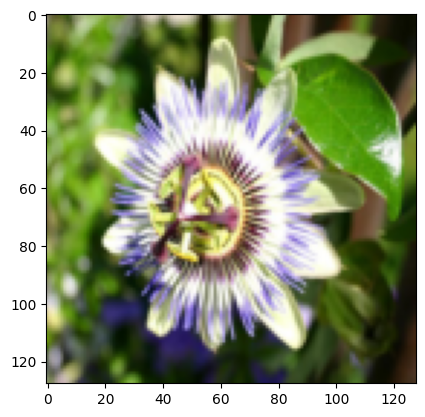

In [10]:
import matplotlib.pyplot as plt
import torchvision

def show_grid(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    

show_grid(torchvision.utils.make_grid(ds[0]["image"], normalize=True))
# show_grid(next(iter(ds))['wrong_image'])

In [11]:
def plot_output(generator):
    plt.clf()
    with torch.no_grad():
        generator.eval()
        test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
        generator.train()
        
        grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
        show_grid(grid)

In [12]:
import torch.optim as optim

generator = Generator(100, 128, 3, 768, 256).to(device)
discriminator = Discriminator(3, 128, 768, 256).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()



In [13]:
import time

epochs = 500

for epoch in range(epochs):
    d_losses, g_losses = [], []
    epoch_time = time.time()
    
    for batch in dataloader:
        images = batch["image"].to(device)
        embed_captions = batch["embed_caption"].to(device)
        wrong_images = batch["wrong_image"].to(device)
        
        # labels
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)
        
        # training the discriminator
        optimizer_D.zero_grad()
        
        # gen fake image
        noise = torch.rand(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)
        
        # compute real loss
        outputs, _ = discriminator(images, embed_captions)
        real_loss = bce_loss(outputs, real_labels)
        
        # compute contrastive loss for wrong image
        outputs, _ = discriminator(wrong_images, embed_captions)
        wrong_loss = bce_loss(outputs, fake_labels)
        
        # compute fake loss
        outputs, _ = discriminator(fake_images.detach(), embed_captions)
        fake_loss = bce_loss(outputs, real_labels)
        
        d_loss = real_loss + fake_loss + wrong_loss
        
        d_loss.backward()
        
        optimizer_D.step()
        d_losses.append(d_loss.item())
        
        # training the generator
        optimizer_G.zero_grad()
        
        # create noise
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)
        
        outputs, fake_features = discriminator(fake_images, embed_captions)
        _, real_features = discriminator(images, embed_captions)
        activation_fake = torch.mean(fake_features, 0)
        activation_real = torch.mean(real_features, 0)
        
        real_loss = bce_loss(outputs, real_labels)
        g_loss = real_loss + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, images)
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(real_loss.item())
    
    avg_d_loss = sum(d_losses) / len(d_losses)
    avg_g_loss = sum(g_losses) / len(g_losses)
    if (epoch+1) % 10 == 0:
        plot_output(generator)
        
    print(f"Epoch [{epoch+1}/{epochs}], D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}, Time: {time.time() - epoch_time}")
    
model_save_path = "./save_model"
torch.save(generator.state_dict(), os.path.join(model_save_path, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(model_save_path, "discriminator.pth"))
        


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>